## analyzing and visualizing seasonal dependence of fires_data

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlalchemy
import psycopg2
from sql_functions import get_engine
from sql_functions import get_sql_config
from sql_functions import get_dataframe
import numpy as np
from scipy.stats import pearsonr


In [2]:
#download fires_data from our SQL base with columns unique_id, state_name, combined_discovery_date and fire_size
fires_data = get_dataframe('SELECT unique_id, state_name, combined_discovery_date, fire_size FROM capstone_wildfire.fires_data_v1_rdy_to_clean_rows')

In [3]:
#download weather_data from our SQL base
weather_data = get_dataframe('SELECT * FROM capstone_wildfire.combined_weather_data_v4')

In [4]:
#checking the fires_data shape in order to verify a complete set
fires_data.shape

(1674438, 4)

In [5]:
#creating a 'month' column in fires_data just to contain the month as integer to better group by month
fires_data['month'] = fires_data['combined_discovery_date'].dt.month


In [6]:
#checking 'month' column values
fires_data['month'].unique()

array([ 8,  5,  6,  7, 10, 11,  1,  9,  2, 12,  3,  4], dtype=int32)

/var/folders/71/74jym8nn07z_r531l25_2hd00000gn/T/ipykernel_2338/2569067673.py:19: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


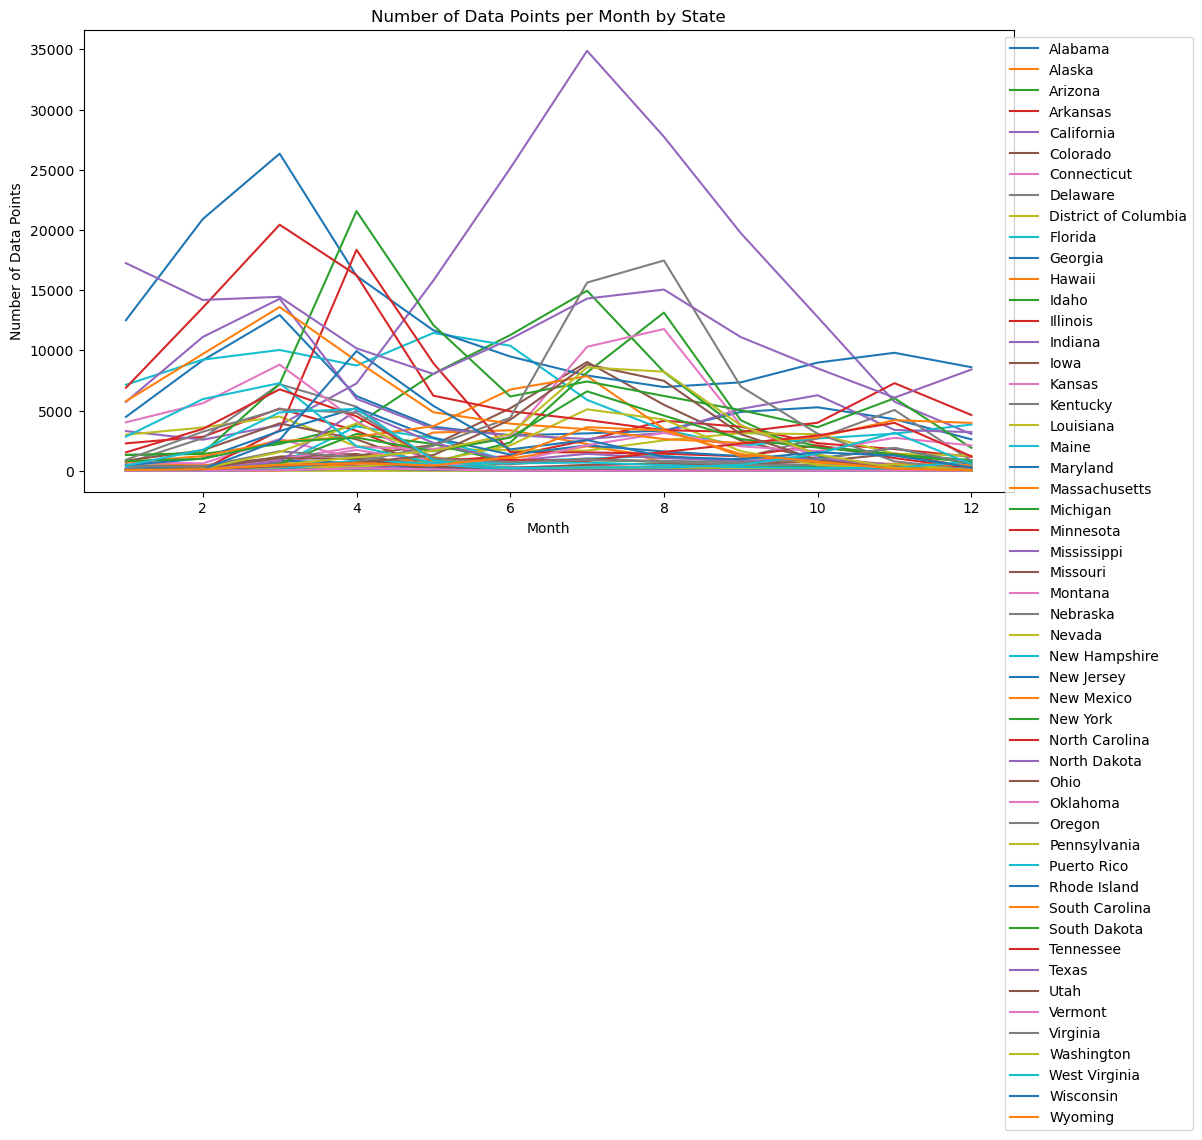

In [7]:
#visualize sum of fires per month by state
#group the data by 'month' and 'state_name' and count the occurrences
grouped_data = fires_data.groupby(['month', 'state_name']).size().unstack().fillna(0)

# create a line chart for each state
fig, ax = plt.subplots(figsize=(12, 6))

# Loop through each state and plot the data as a line chart
for state in grouped_data.columns:
    ax.plot(grouped_data.index, grouped_data[state], label=state)

# Set labels and title
ax.set_xlabel('Month')
ax.set_ylabel('Number of Data Points')
ax.set_title('Number of Data Points per Month by State')
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

# Show the plot
plt.tight_layout()
plt.show()


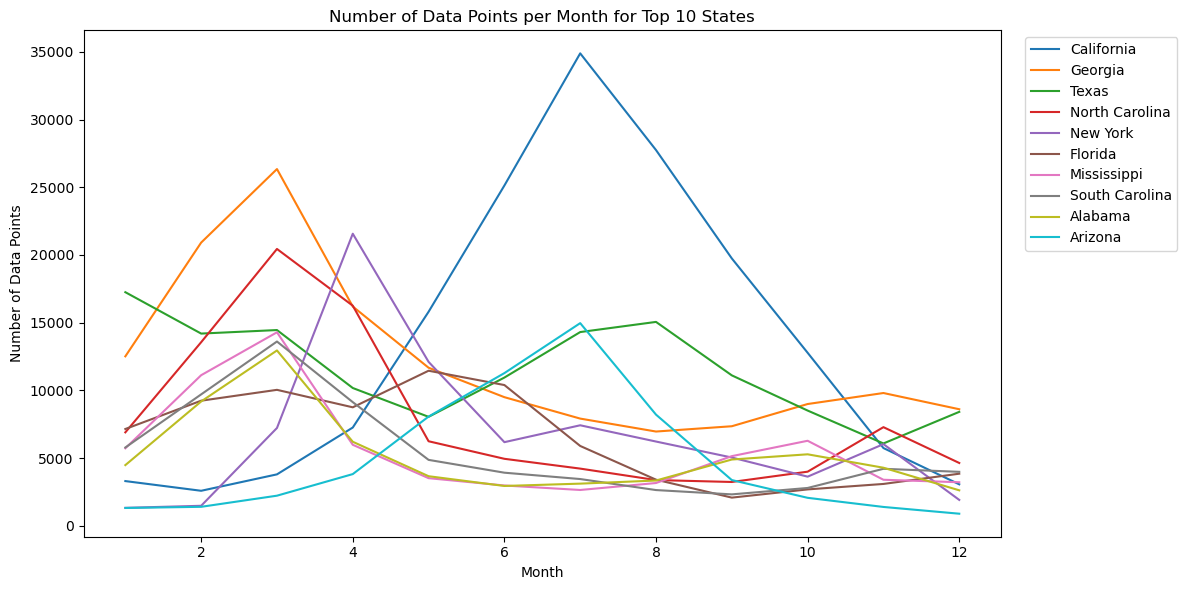

In [8]:
#creating a visualization just for the top 10 states most shown in the dataset

# creating a top 10 states dataframe with the largest of grouped_data
top_10_states = grouped_data.sum().nlargest(10).index

# Filter the data to include only the top 10 states
filtered_data = grouped_data[top_10_states]

# Now, you can create a line chart for each of the top 10 states
fig, ax = plt.subplots(figsize=(12, 6))

# Loop through each state and plot the data as a line chart
for state in filtered_data.columns:
    ax.plot(filtered_data.index, filtered_data[state], label=state)

# Set labels and title
ax.set_xlabel('Month')
ax.set_ylabel('Number of Data Points')
ax.set_title('Number of Data Points per Month for Top 10 States')
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

# Show the plot
plt.tight_layout()
plt.show()

In [9]:
weather_data.head(10)

,date,average_temp_c,minimum_temp_c,maximum_temp_c,precipitation_mm,snow_mm,wind_direction_deg,windspeed_kmh,peak_wind_gust_kmh,air_pressure_hpa,sunshine_min,station_id,weather_station_name,states,latitude,longitude
0,2010-10-20,20.1,17.8,22.8,1.8,NaN,NaN,13.0,NaN,NaN,NaN,72278,Phoenix Sky Harbor Airport,Arizona,33.4333,-112.050
1,2010-10-21,18.4,14.4,22.2,4.6,NaN,NaN,6.5,NaN,1014.5,NaN,72278,Phoenix Sky Harbor Airport,Arizona,33.4333,-112.050
2,2010-10-22,19.1,15.6,23.3,0.0,NaN,NaN,7.9,NaN,1013.4,NaN,72278,Phoenix Sky Harbor Airport,Arizona,33.4333,-112.050
3,2010-10-23,20.1,14.4,25.6,0.0,NaN,NaN,6.5,NaN,1014.7,NaN,72278,Phoenix Sky Harbor Airport,Arizona,33.4333,-112.050
4,2010-10-24,21.6,16.1,27.8,0.0,NaN,NaN,6.1,NaN,1014.6,NaN,72278,Phoenix Sky Harbor Airport,Arizona,33.4333,-112.050
5,2010-10-25,21.1,16.7,25.6,0.0,NaN,NaN,9.4,NaN,1008.0,NaN,72278,Phoenix Sky Harbor Airport,Arizona,33.4333,-112.050
6,2005-03-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KMIB0,Minot / Minot Air Force Base,North Dakota,48.4158,-101.358
7,2010-10-26,21.2,15.6,27.2,0.0,NaN,NaN,9.7,NaN,1007.5,NaN,72278,Phoenix Sky Harbor Airport,Arizona,33.4333,-112.050
8,2010-10-27,21.5,14.4,27.8,0.0,NaN,NaN,7.2,NaN,1014.6,NaN,72278,Phoenix Sky Harbor Airport,Arizona,33.4333,-112.050
9,2010-10-28,24.0,15.0,33.3,0.0,NaN,NaN,9.0,NaN,1017.4,NaN,72278,Phoenix Sky Harbor Airport,Arizona,33.4333,-112.050


In [10]:
#saving the month into a new column 'month'
weather_data['month'] = weather_data['date'].dt.month

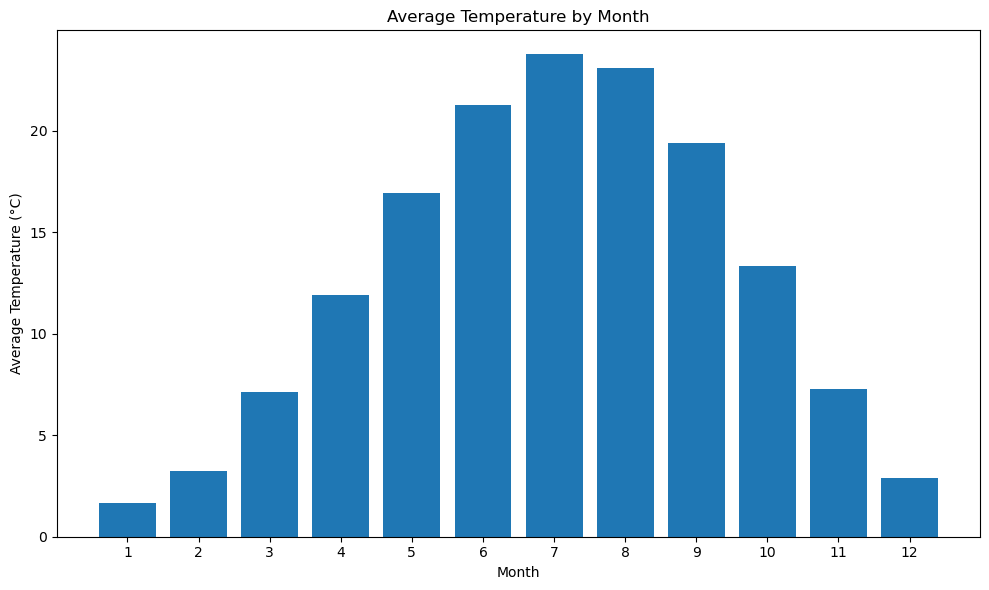

In [11]:
# Group the data by 'month' and calculate the average temperature for each month
monthly_avg_temp = weather_data.groupby('month')['average_temp_c'].mean()

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(monthly_avg_temp.index, monthly_avg_temp, tick_label=monthly_avg_temp.index)

# Set labels and title
plt.xlabel('Month')
plt.ylabel('Average Temperature (°C)')
plt.title('Average Temperature by Month')

# Show the plot
plt.tight_layout()
plt.show()


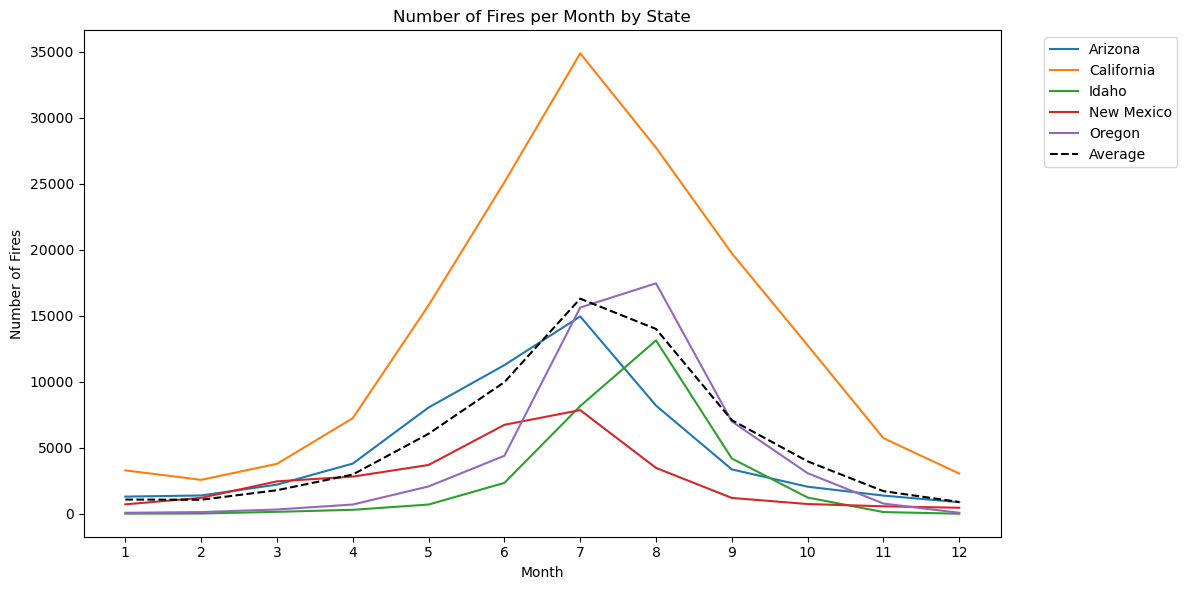

In [33]:

# Define the list of states to include in the visualization
selected_states = ['California', 'Oregon', 'Idaho', 'New Mexico', 'Arizona']

# Filter the data to include only the selected states
filtered_data = fires_data[fires_data['state_name'].isin(selected_states)]

# Group the filtered data by 'month' and 'state_name' and count the occurrences
grouped_data = filtered_data.groupby(['month', 'state_name']).size().unstack().fillna(0)

# Calculate the average number of fires for each month
average_line = grouped_data.mean(axis=1)

# Create a line chart for each state
fig, ax = plt.subplots(figsize=(12, 6))

# Loop through each state and plot the data as a line chart
for state in grouped_data.columns:
    ax.plot(grouped_data.index, grouped_data[state], label=state)

# Plot the average line
ax.plot(grouped_data.index, average_line, label='Average', linestyle='--', color='black')

# Set labels and title
ax.set_xlabel('Month')
ax.set_ylabel('Number of Fires')
ax.set_title('Number of Fires per Month by State')
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

# Set the x-axis ticks to be the unique values from the 'month' column
ax.set_xticks(grouped_data.index)

# Show the plot
plt.tight_layout()
plt.show()

In [38]:
state_counts = fires_data['state_name'].value_counts().loc[['California', 'Oregon', 'Idaho', 'New Mexico', 'Arizona']]
print(state_counts)

state_name
California    161780
Oregon         51794
Idaho          30469
New Mexico     32019
Arizona        58929
Name: count, dtype: int64


In [40]:
state_counts_by_month = filtered_data.groupby(['month', 'state_name']).size().unstack(fill_value=0)
print(state_counts_by_month)

state_name  Arizona  California  Idaho  New Mexico  Oregon
month                                                     
1              1309        3295     20         722      83
2              1395        2579     29        1216     138
3              2217        3792    156        2465     333
4              3812        7251    309        2824     709
5              8060       15801    708        3706    2080
6             11271       25127   2348        6747    4403
7             14961       34888   8168        7862   15633
8              8204       27745  13143        3483   17466
9              3370       19740   4197        1209    6999
10             2059       12772   1239         746    3083
11             1385        5735    138         575     782
12              886        3055     14         464      85


In [25]:
filtered_data.shape

(334991, 5)

In [27]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 334991 entries, 0 to 1674437
Data columns (total 5 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   unique_id                334991 non-null  int64         
 1   state_name               334991 non-null  object        
 2   combined_discovery_date  334991 non-null  datetime64[ns]
 3   fire_size                334991 non-null  float64       
 4   month                    334991 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(1)
memory usage: 14.1+ MB


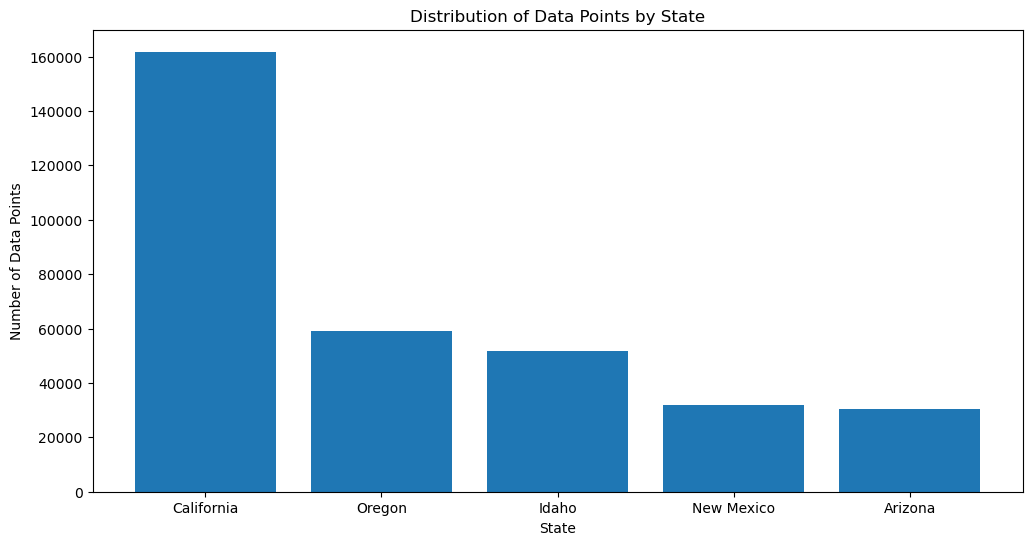

In [31]:
# Create a bar plot to visualize the distribution of data points by state
plt.figure(figsize=(12, 6))
plt.bar(selected_states, filtered_data['state_name'].value_counts())
plt.xlabel('State')
plt.ylabel('Number of Data Points')
plt.title('Distribution of Data Points by State')
plt.show()


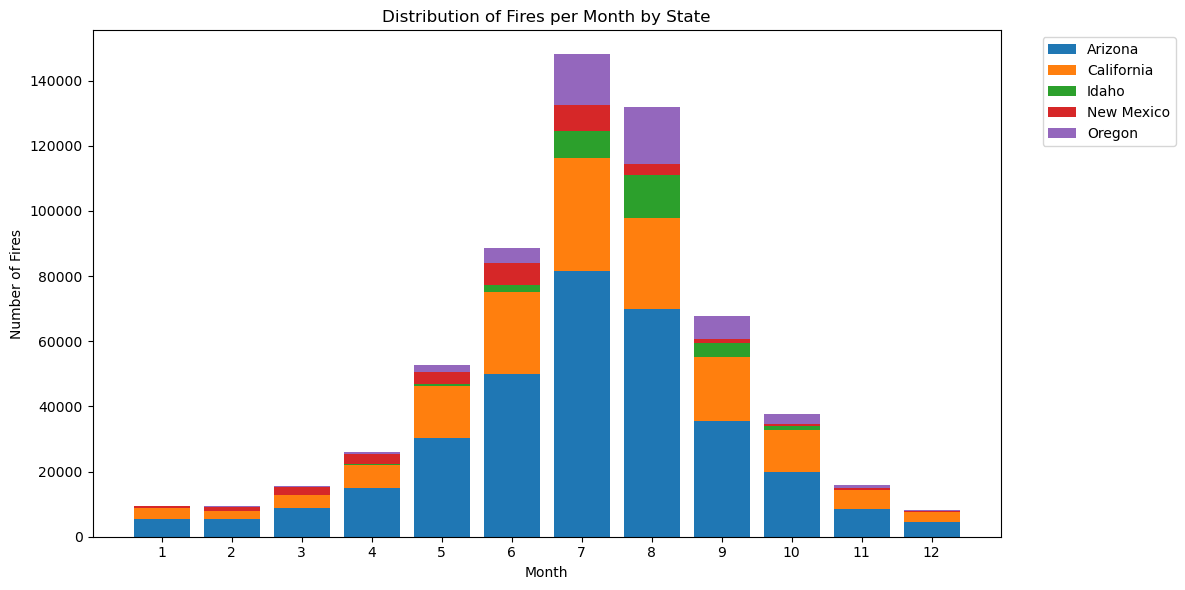

In [35]:
# Create a stacked bar chart
fig, ax = plt.subplots(figsize=(12, 6))

# Loop through each state and add a stacked bar for each month
bottom = None
for state in grouped_data.columns:
    ax.bar(grouped_data.index, grouped_data[state], label=state, bottom=bottom)
    if bottom is None:
        bottom = grouped_data[state]
    else:
        bottom += grouped_data[state]

# Set labels and title
ax.set_xlabel('Month')
ax.set_ylabel('Number of Fires')
ax.set_title('Distribution of Fires per Month by State')
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

# Set the x-axis ticks to be the unique values from the 'month' column
ax.set_xticks(grouped_data.index)

# Show the plot
plt.tight_layout()
plt.show()

### calculating correlation for our chosen 5 states

In [45]:
california_data = fires_data[fires_data['state_name'] == 'California']
arizona_data = fires_data[fires_data['state_name'] == 'Arizona']
idaho_data = fires_data[fires_data['state_name'] == 'Idaho']
new_mexico_data = fires_data[fires_data['state_name'] == 'New Mexico']
oregon_data = fires_data[fires_data['state_name'] == 'Oregon']

In [59]:
correlation_coefficient1, p_value1 = pearsonr(california_data['month'], california_data['unique_id'])
print('Correlation on Californian wildfires over the months:')
print('Pearson correlation coefficient:', correlation_coefficient1)
print('p-value:', p_value1)

Correlation on Californian wildfires over the months:
Pearson correlation coefficient: -0.06684955795126829
p-value: 1.3500917693569184e-159


In [60]:
correlation_coefficient2, p_value2 = pearsonr(idaho_data['month'], idaho_data['unique_id'])
print('Correlation on Idaho wildfires over the months:')
print('Pearson correlation coefficient:', correlation_coefficient2)
print('p-value:', p_value2)

Correlation on Idaho wildfires over the months:
Pearson correlation coefficient: -0.05507968854733264
p-value: 6.502104481817849e-22


In [61]:
correlation_coefficient3, p_value3 = pearsonr(arizona_data['month'], arizona_data['unique_id'])
print('Correlation on Arizonan wildfires over the months:')
print('Pearson correlation coefficient:', correlation_coefficient3)
print('p-value:', p_value3)

Correlation on Arizonan wildfires over the months:
Pearson correlation coefficient: -0.06557500739778023
p-value: 3.602249873056001e-57


In [62]:
correlation_coefficient4, p_value4 = pearsonr(oregon_data['month'], oregon_data['unique_id'])
print('Correlation on Oregon wildfires over the months:')
print('Pearson correlation coefficient:', correlation_coefficient4)
print('p-value:', p_value4)

Correlation on Oregon wildfires over the months:
Pearson correlation coefficient: -0.06042972182182171
p-value: 4.137548318134141e-43


In [63]:
correlation_coefficient5, p_value5 = pearsonr(new_mexico_data['month'], new_mexico_data['unique_id'])
print('Correlation on New Mexico wildfires over the months:')
print('Pearson correlation coefficient:', correlation_coefficient5)
print('p-value:', p_value5)

Correlation on New Mexico wildfires over the months:
Pearson correlation coefficient: -0.04936589908802726
p-value: 9.700738898462012e-19


### Visualization of distribution from states / months

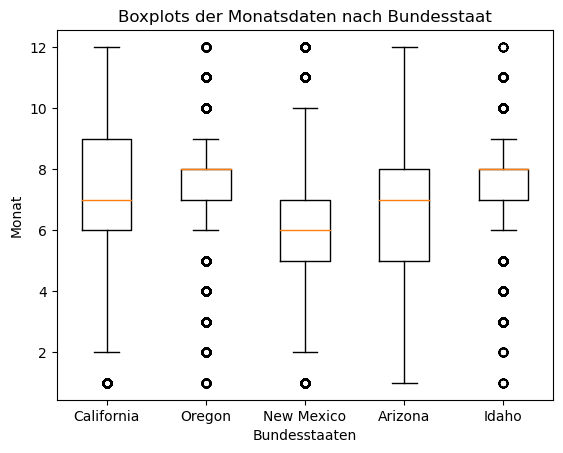

In [65]:
# Liste der Datensätze
datasets = [california_data, oregon_data, new_mexico_data, arizona_data, idaho_data]

# Namen der Datensätze
dataset_names = ['California', 'Oregon', 'New Mexico', 'Arizona', 'Idaho']

# Erstellen Sie eine leere Figur und Achsen
fig, ax = plt.subplots()

# Erstellen Sie die Boxplots für 'month' in jedem Datensatz
boxplots = ax.boxplot([dataset['month'] for dataset in datasets], labels=dataset_names)

# Beschriftungen hinzufügen
ax.set_xlabel('Bundesstaaten')
ax.set_ylabel('Monat')
ax.set_title('Boxplots der Monatsdaten nach Bundesstaat')

# Zeigen Sie die Grafik an
plt.show()